In [1]:
from Algorithm import Gaussian_Process
from Algorithm import LA_Bayessian_Quadrature
from Algorithm import Mesh
from Algorithm import Kernels
import Target_Function as tf

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
opt1 = tf.Option('call', 0, 95, .25, 1.0,  15, 1)
opt2 = tf.Option('put',  1, 110, .2,  0.5,  5, 1)
portfolio = tf.OptionPortfolio(.03, 50, 150,[opt1, opt2])
D = len(portfolio.options)
func = portfolio.target_function

print(f"Analytic portfolio Δ : {func([portfolio.alter(102.0),portfolio.alter(98.0)]):,.4f}")

Analytic portfolio Δ : 0.3416


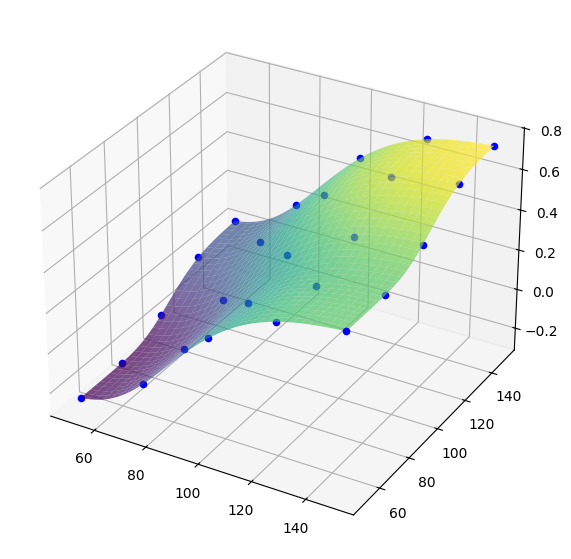

In [3]:
a = np.linspace(0., 1., 101)
b = np.linspace(0., 1., 101)
# 计算 z 值
A, B = np.meshgrid(a, b)
C = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] = func([A[i, j], B[i, j]])

# 4. 绘图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(A), portfolio.to_initial(B), C, cmap='viridis', alpha=0.7)

# 生成二维输入网格
xx = np.linspace(0., 1., 5)
yy = np.linspace(0., 1., 5)
xxx, yyy = np.meshgrid(xx, yy)
X = np.vstack([xxx.ravel(), yyy.ravel()]).T
# 生成 Y
Y = np.array([func(x) for x in X])


for idx, i in enumerate(X):
    ax.scatter(portfolio.to_initial(i[0]),
               portfolio.to_initial(i[1]),
               Y[idx], color='blue', s=20)
plt.show()

In [4]:
beta = np.concatenate([
    np.array([-0.5]),
    np.random.uniform(-2, 0, size=11 * D)
])

In [5]:
mesh1 = Mesh.get_points_Sobol(X,_)

GP = Gaussian_Process.GaussianProcess(Kernels.K_lin_mat2_10,beta,X,Y,mesh = mesh1)


In [6]:
GPs, int_params, _, _ = LA_Bayessian_Quadrature.ABC_D(
    func,                # 你定义的目标函数（black-box，输入 [x1, x2]，返回 float）
    GP,                  # 你初始化好的 GaussianProcess 对象
    Mesh.get_points_Sobol,   # 用于生成新候选点的函数（mesh.py 中的默认高维函数）
    n=30,                # 进行 30 次自适应采样（共 31 个点）
    lambd=[30, 1],       # 正则项参数，推荐默认即可
    point_mesh = mesh1
)

Dimensions: 2 , Sobol: 7 , Steps: 31
Step 1 of 31, Time: 9.28, Result: [2.55249401e-01 2.43640805e-04]
Step 2 of 31, Time: 9.22, Result: [2.58713539e-01 2.15236776e-04]
Step 3 of 31, Time: 9.18, Result: [2.66468185e-01 1.88267055e-04]
Step 4 of 31, Time: 9.24, Result: [2.70146336e-01 1.57905437e-04]
Step 5 of 31, Time: 10.02, Result: [2.80051456e-01 1.31613881e-04]
Step 6 of 31, Time: 9.28, Result: [2.80733862e-01 1.06057902e-04]
Step 7 of 31, Time: 9.27, Result: [2.85102289e-01 8.35957907e-05]
Step 8 of 31, Time: 9.42, Result: [2.84594707e-01 6.89811256e-05]
Step 9 of 31, Time: 9.39, Result: [2.84443643e-01 5.78120376e-05]
Step 10 of 31, Time: 9.44, Result: [2.84178166e-01 4.57723084e-05]
Step 11 of 31, Time: 9.45, Result: [2.84652036e-01 3.63972203e-05]
Step 12 of 31, Time: 9.37, Result: [2.84831404e-01 3.05702044e-05]
Step 13 of 31, Time: 9.46, Result: [2.85745928e-01 2.55713018e-05]
Step 14 of 31, Time: 9.49, Result: [2.85809654e-01 2.16717729e-05]
Step 15 of 31, Time: 9.64, Result

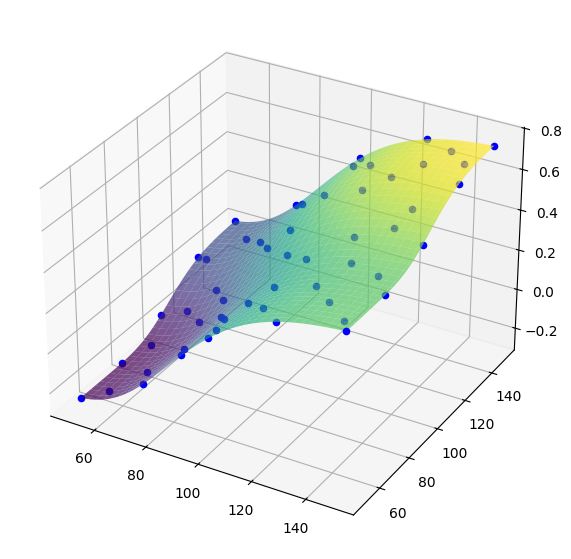

In [7]:
final_GP = GPs[-1]
pa = np.linspace(0., 1., 101)
pb = np.linspace(0., 1., 101)
PA, PB = np.meshgrid(pa, pb)
PC = np.zeros_like(PA)
for i in range(PA.shape[0]):
    for j in range(PA.shape[1]):
        PC[i, j] = func([PA[i, j], PB[i, j]])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(PA), portfolio.to_initial(PB), PC, cmap='viridis', alpha=0.7)


px = []
for i in range(len(final_GP.X.T[0])):
    px.append([final_GP.X.T[0][i], final_GP.X.T[1][i]])
py = [func(i) for i in px]


for idx, i in enumerate(px):
    ax.scatter(portfolio.to_initial(i[0]),portfolio.to_initial(i[1]), py[idx], color='blue', s=20)
plt.show()